In [1]:
import os, sys, argparse
from collections import OrderedDict

import numpy as np

# Main C3 objects
from c3.libraries import constants
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.utils.tf_utils import tf_project_to_comp

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.optimizers.optimalcontrol import OptimalControl

#%matplotlib widget

from four_level_transmons.utilities import *
from four_level_transmons.plotting import *
from four_level_transmons.custom_envelopes import *
from four_level_transmons.DataOutput import DataOutput

import four_level_transmons.custom_gates as custom_gates
tf.config.run_functions_eagerly(True)

2022-05-07 14:41:22.816669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 14:41:22.816725: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"

=========== WARNING: no output directory specified ============


In [3]:
def printSignal(exper: Experiment, qubit: chip.Qubit,
                gate: gates.Instruction, output: DataOutput,
                states: Dict[float, str] = None):
    # generate signal
    signal = generateSignal(exper, gate, qubit)
    ts = signal["ts"].numpy()
    values = signal["values"].numpy()

    # save data
    peakFrequencies, peakValues = findFrequencyPeaks(ts, values, 4)
    print("peaks: ", np.sort(peakFrequencies))
    output.save([ts, values], "signal")

    # plot
    plotSignalAndSpectrum(ts, real=values, filename=output.createFileName("signal", "svg"), spectralThreshold=None)
    plotSignalAndSpectrum(ts, real=values, filename=output.createFileName("signal_detail", "svg"), spectralThreshold=5e-5)
    plotSignalAndSpectrum(ts, real=values, filename=output.createFileName("signal_detail_with_states", "svg"), states=states, spectralThreshold=5e-5)


def printTimeEvolution(exper: Experiment, init: tf.Tensor, gate: gates.Instruction,
                       labels: List[str], output: DataOutput):
    populations = calculatePopulation(exper, init, [gate.get_key()])

    output.save(populations, "population")
    plotPopulation(exper, populations, sequence=[gate.get_key()],
                   labels=labels, filename=output.createFileName("population", "svg"))


def stateEntropy(state: tf.Tensor):
    rho = densityMatrix(state)
    rho = tf_project_to_comp(rho, dims=[5] * 2, outdims=[4] * 2)
    rhoBD = partialTrace(rho, [1, 3])
    rhoB = partialTrace(rhoBD, [0])
    return entanglementEntropy(rhoB)


def printEntanglementEvolution(exper: Experiment, gate: gates.Instruction, output: DataOutput):
    entropies = []
    for state in [(0, 1), (0, 5), (1, 6), (5, 6)]:
        psi_init = np.zeros(shape=(model.tot_dim,))
        psi_init[state[0]] = psi_init[state[1]] = 1 / np.sqrt(2)
        entropy = calculateObservable(exper, np.array(psi_init), [gate.get_key()], stateEntropy)
        entropies.append(entropy)
    entropies = np.array(entropies)
    plotPopulation(exper, entropies, sequence=[gate.get_key()],
                   labels=["00+01", "00+10", "01+11", "10+11"],
                   filename=output.createFileName("entanglement", "svg"),
                   labelY="Entropy")


def printMatrix(M: np.array, labels: List[str], name: str, output: DataOutput):
    #plotComplexMatrix(M, xlabels=labels, ylabels=labels, filename=output.createFileName(name))
    plotComplexMatrixHinton(M, maxAbsolute=1, xlabels=labels, ylabels=labels, gridColour="gray",
                            filename=output.createFileName(name, "svg"),
                            colourMap='hsv')
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=True,
    #                            filename=output.createFileName(name + "_phase"))
    #plotComplexMatrixAbsOrPhase(M, xlabels=labels, ylabels=labels, phase=False,
    #                            filename=output.createFileName(name + "_abs"))


def printPropagator(exper: Experiment, gate: gates.Instruction,
                    labels: List[str], output: DataOutput):
    U = exper.propagators[gate.get_key()]
    output.save(U, "propagator")
    printMatrix(U, labels, "propagator", output)


def printAllSignals(exper: Experiment, qubit: chip.Qubit, output: DataOutput, directory: str):
    try:
        os.mkdir(output.getDirectory() + "/" + directory)
    except:
        pass
    drive = getDrive(exper.pmap.model, qubit)
    outputs = exper.pmap.generator.global_signal_stack[drive.name]
    for name, values in outputs.items():
        filename = output.createFileName(directory + "/device_" + name, "svg")
        time = values["ts"].numpy()
        if name.startswith("LO"):
            #time = time[:100]
            re = values["inphase"].numpy()
            im = values["quadrature"].numpy()
            plotSignalAndSpectrum(time, real=re, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_real", "svg"))
            plotSignalAndSpectrum(time, real=im, min_signal_limit=None,
                                  spectralThreshold=5e-4,
                                  filename=output.createFileName(directory + "/device_" + name + "_imag", "svg"))
        elif "values" in values:
            signal = values["values"].numpy()
            plotSignalAndSpectrum(time, signal, min_signal_limit=None, filename=filename, spectralThreshold=5e-4)
        else:
            signal = values["inphase"].numpy() ** 2 + values["quadrature"].numpy() ** 2
            plotSignalAndSpectrum(time, real=values["inphase"].numpy(), imag=values["quadrature"].numpy(),
                                  min_signal_limit=None, spectralThreshold=5e-4, filename=filename)


def optimise(output: DataOutput, qubit: chip.PhysicalComponent, exp: Experiment,
             algorithm, options, gate: gates.Instruction):
    # set up the optimiser
    opt = OptimalControl(
        dir_path=output.getDirectory(),
        fid_func=fidelities.unitary_infid_set,
        fid_subspace=[qubit.name],
        pmap=exp.pmap,
        algorithm=algorithm,
        options=options,
        run_name=gate.name,
        fid_func_kwargs={
            "active_levels": 4
        }
    )
    exp.set_opt_gates([gate.get_key()])
    opt.set_exp(exp)

    # add the callback
    infidelities = []
    def fidelityCallback(index, fidelity):
        print(index, fidelity)
        infidelities.append(fidelity)
    opt.set_callback(fidelityCallback)

    # run optimisation
    opt.optimize_controls()
    print(opt.current_best_goal)
    exp.pmap.print_parameters()

    return infidelities


#def loadEnvelopes(filename: str) -> List[pulse.Envelope]:
#    stored_pmap = PMap()
#    stored_pmap.read_config(filename)
#    return None

In [4]:
# Initialise the qubits and drive lines
qubit_levels = 5
qubit_frequency = 5e9
anharmonicity = -300e6
t1 = 25e-6
t2star = 35e-6
qubit_temp = 50e-3
level_labels = ["$|0,0\\rangle$", "$|0,1\\rangle$", "$|1,0\\rangle$", "$|1,1\\rangle$", "leakage"]
output = DataOutput(output_dir, file_suffix='before')

qubit = createQubits([qubit_levels], [qubit_frequency], [anharmonicity], [t1],
                      [t2star], qubit_temp)[0]
drive = createDrives([qubit])[0]

2022-05-07 14:41:29.115590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 14:41:29.115639: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 14:41:29.115682: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist


In [5]:
# Create the model
model = Mdl([qubit], [drive])
model.set_lindbladian(False)
model.set_dressed(False)
model.set_FR(False)

energies = qubit.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi)
print("energies: ", energies)
transitions = np.array([energies[i + 1] - energies[i] for i in range(len(energies) - 1)])
print("transition frequencies: ", transitions)

energies:  [0.00e+00 5.00e+09 9.70e+09 1.41e+10 1.82e+10]
transition frequencies:  [5.0e+09 4.7e+09 4.4e+09 4.1e+09]


In [6]:
stored_pmap = PMap()
stored_pmap.read_config("./optimised_params/1transmon/X_q1_200ns.json")
stored_params = stored_pmap.asdict()["X_q1[0]"]
stored_params_d = stored_params["drive_channels"]["d1"]

/home/user/c3/c3/signal/gates.py:104: UserWarning: No ideal gate found for gate:  . Use set_ideal() explicitly.
  warnings.warn(
/home/user/c3/c3/signal/gates.py:104: UserWarning: No ideal gate found for gate: X_q1. Use set_ideal() explicitly.
  warnings.warn(


In [7]:
# Create the generator
generator = createGenerator2LOs([drive], useDrag=True)

In [8]:
# Envelopes and carriers
t_final = 200e-9
carrier_freqs = [0.5 * (transitions[0] + transitions[1]), 0.5 * (transitions[1] + transitions[2])]
#carrier_freqs = [transitions[0], transitions[2]]
#carrier_freqs = [4.854e+09, 4.545e+09]
print("carrier: ", carrier_freqs)

pulse_t_final = t_final - 2e-9
pulse_sigmas = [t_final / 5, t_final / 5]
#integrated_amp = np.sqrt(np.pi/2) / (pulse_t_final * 1e9)
#pulse_amps = [integrated_amp, 0.7 * integrated_amp]  #[0.06, 0.03]
pulse_amps = [0.8 * 1.5, 0.6 * 1.5]
pulse_deltas = [-0.01, 0.01]
pulse_xy_angles = [-0.01, 0.01]
pulse_freq_offsets = [1, 1]  #[0.5e6, 0.5e6]

envelopes = []
carriers = []
'''
for i in range(0, len(carrier_freqs)):
    gaussian_envelope = createGaussianPulse(
        t_final=pulse_t_final,
        sigma=pulse_sigmas[i],
        amp=pulse_amps[i],
        delta=pulse_deltas[i],
        xy_angle=pulse_xy_angles[i],
        freq_off=pulse_freq_offsets[i]
    )
    gaussian_envelope.name = f"envelope_d1_{i + 1}"
    envelopes.append(gaussian_envelope)

    carrier_parameters = {
        "freq": Qty(value=carrier_freqs[i], min_val=0.9 * carrier_freqs[i], max_val=1.1 * carrier_freqs[i], unit="Hz 2pi"),
        "framechange": Qty(value=0, min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
    }
    carriers.append(pulse.Carrier(
        name=f"carrier_d1_{i+1}",
        desc="Frequency of the local oscillator",
        params=carrier_parameters,
    ))
'''

amp_params = [
    Qty(value=0.4, min_val=0.35, max_val=0.45, unit='V'),
    Qty(value=0.3, min_val=0.25, max_val=0.35, unit='V')
]

for i in range(0, len(carrier_freqs)):
    env = stored_params_d[f"envelope_d1_{i + 1}"]
    #env = convertToPWC(stored_params_d[f"envelope_{driveName}_{i + 1}"], numPWCPieces)
    #env = scaleGaussianEnvelope(env, 200.0 / 60.0)
    env.params["amp"] = amp_params[i] #scaleQuantity(env.params["amp"], 0.77)
    envelopes.append(env)

    carrier = stored_params_d[f"carrier_d1_{i + 1}"]
    #shift = df if idx == 0 else -df
    #carrier.params["freq"].set_value(
    #    carrier_freqs[dstIdx][i]
    #    #carrier.params["freq"].get_value() / (2 * np.pi) + df
    #)
    #carrier.params["freq"] = Qty(
    #    value=carrier_freqs[i],
    #    min_val=0.95 * carrier_freqs[i],
    #    max_val=1.05 * carrier_freqs[i],
    #    unit="Hz 2pi"
    #)
    carriers.append(carrier)

carrier:  [4850000000.000001, 4549999999.999998]


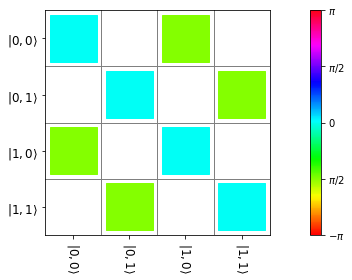

/home/user/c3/c3/signal/gates.py:104: UserWarning: No ideal gate found for gate: rx90p_q1. Use set_ideal() explicitly.
  warnings.warn(


In [9]:
# Gate instructions
#ideal_gate = qt_utils.np_kron_n([constants.x90p, constants.Id])
#ideal_gate = qt_utils.np_kron_n([constants.Id, constants.Id])
ideal_gate = qt_utils.np_kron_n([constants.GATES["rx90p"], constants.Id])
#ideal_gate = np.array([[0, 1, 0, 0], [-1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
#ideal_gate = np.array([[0,0,1j,0], [0,1,0,0], [-1j,0,0,0], [0,0,0,1]])
printMatrix(ideal_gate, level_labels[:4], "ideal_gate", output)

gate = gates.Instruction(
    name="rx90p_q1",
    targets=[0],
    t_start=0.0,
    t_end=t_final,
    channels=[drive.name],
    ideal=ideal_gate,
)
for env in envelopes:
    gate.add_component(copy.deepcopy(env), drive.name)
for carrier in carriers:
    gate.add_component(copy.deepcopy(carrier), drive.name)

In [15]:
# all energy levels with labels
stateEnergies = []
H = model.get_Hamiltonian()
for i in range(qubit_levels):
    state = np.zeros(model.tot_dim)
    state[i] = 1
    energy = np.vdot(state.T, np.matmul(H, state)).real / (2 * np.pi)
    stateEnergies.append((np.round(energy, 5), f"{i}"))

# all energy transitions
items = sorted(stateEnergies, key=lambda x: x[0])
transitions = []
for i in range(len(items)):
    for j in range(len(items)):
        if i != j:
            #print(i, j)
            E = items[j][0] - items[i][0]
            if E > 0:
                transitions.append((E, items[i][1] + " - " + items[j][1]))

(0.0, '0')
(5000000000.0, '1')
(9700000000.0, '2')
(14100000000.0, '3')
(18200000000.0, '4')


LO2 inputs:  0
Mixer2 inputs:  2
LO1 inputs:  0
Mixer1 inputs:  2
RealMixer inputs:  2
VoltsToHertz inputs:  1


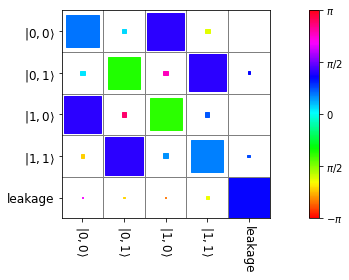

In [11]:
# Set up the experiment
parameter_map = PMap(instructions=[gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates([gate.get_key()])

printSignal(exp, qubit, gate, output=output, states=transitions)

unitaries = exp.compute_propagators()
printPropagator(exp, gate, level_labels, output)

printAllSignals(exp, qubit, output, directory="devices_before")

In [ ]:
# Specify the initial state
psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = [gate.get_key()]

printTimeEvolution(exp, init_state, gate, level_labels, output)
parameter_map.write_config(output.createFileName('parameter_map', 'json'))

In [ ]:
# Specify the parameters to be optimised and initialise the optimiser
opt_map = []
for env in envelopes:
    opt_map.append([(gate.get_key(), "d1", env.name, "amp")])
    opt_map.append([(gate.get_key(), "d1", env.name, "sigma")])
    opt_map.append([(gate.get_key(), "d1", env.name, "freq_offset")])
    opt_map.append([(gate.get_key(), "d1", env.name, "xy_angle")])
    opt_map.append([(gate.get_key(), "d1", env.name, "delta")])
    opt_map.append([(gate.get_key(), "d1", env.name, "t_final")])
for carrier in carriers:
    opt_map.append([(gate.get_key(), "d1", carrier.name, "freq")])
    #opt_map.append([(gate.get_key(), "d1", carrier.name, "framechange")])
parameter_map.set_opt_map(opt_map)
parameter_map.print_parameters()

In [ ]:
infidelities = optimise(output, qubit, exp, algorithms.lbfgs, {"maxfun": 1000, "ftol": 1e-6}, gate)
#infidelities = optimise(output, qubit, exp, algorithms.cmaes, {"popsize": 12, "spread": 0.05}, gate)

In [ ]:
# Plot results
output = DataOutput(output_dir, file_suffix='after')
plotData(np.arange(len(infidelities)), infidelities, xlabel="Step",
         ylabel="Infidelity", filename=output.createFileName("convergence", "svg"))
printSignal(exp, qubit, gate, output=output, states=transitions)
#printAllSignals(exp, qubit, output, directory="devices_after")
printPropagator(exp, gate, level_labels, output)
printTimeEvolution(exp, init_state, gate, level_labels, output)
parameter_map.write_config(output.createFileName('parameter_map', 'json'))

'''
propagator = np.load('propagator_after.npy')
labels = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle", "leakage"]
labels = [f"${s}$" for s in labels]
plotComplexMatrixHinton(propagator, maxAbsolute=1, xlabels=labels, ylabels=labels, gridColour="gray",
                        filename=None, colourMap='hsv')
'''